## Code for project in Advanced probabilistic Machine learing

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

#### Q4 - A first Gibbs sampler

 Number of samples: 2000 	 Time: 0.1889 seconds 


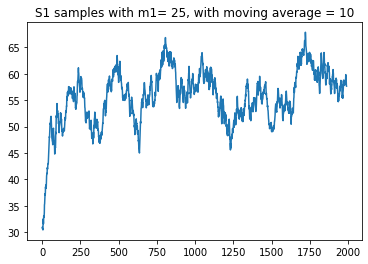

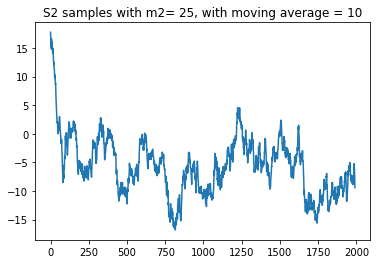

In [4]:
# Hyperparameters
mu_prior = 25
sigma_prior = 40
beta_inv = 1 

m1 = mu_prior
m2 = mu_prior
sig1 = sigma_prior
sig2 = sigma_prior

# Prior distributions
s1 = np.random.normal(m1, np.sqrt(sig1))    
s2 = np.random.normal(m2, np.sqrt(sig2))

# Setting sample parameters
num_samples = 2000
burn_in = 300

# Initial values
s1_samples = np.zeros(num_samples)
s2_samples = np.zeros(num_samples)
s1_samples[0] = s1
s2_samples[0] = s2

# Gibbs sampling
start_time = time.time()
for i in range(num_samples-1):    
    t = stats.truncnorm.rvs(a=0, b=np.inf, loc=(s1_samples[i] - s2_samples[i]), scale=np.sqrt(beta_inv))  # p(t|s1, s2, y)
    
    # Calculating mean and variance for distribution p(s1, s2|t)
    A = np.array([[1, -1]])
    sigma_s = np.array([[sig1, 0], [0, sig2]])
    m_s = np.array([[m1], [m2]])

    S = np.linalg.inv(np.linalg.inv(sigma_s) + (beta_inv)**(-1) * (A.T @ A))
    m = S @ (np.linalg.inv(sigma_s) @ m_s + beta_inv**(-1) * A.T * t)

    # Draw new samples
    s1, s2 = np.random.multivariate_normal(m.ravel(), S)
    s1_samples[i+1], s2_samples[i+1] = s1, s2
print(f" Number of samples: {num_samples} \t Time: {round(time.time() - start_time, 4)} seconds ")

# Setting the smoothing filter parameter
mvg_avg = 10

# Plots the samples drawn for Player 1
plt.plot(np.convolve(s1_samples, np.ones(mvg_avg)/mvg_avg, mode = 'valid'))
plt.title(f'S1 samples with m1= {m1}, with moving average = {mvg_avg}')
plt.show()

# Plots the samples drawn for Player 2
plt.plot(np.convolve(s2_samples, np.ones(mvg_avg)/mvg_avg, mode = 'valid'))
plt.title(f'S2 samples with m2= {m2}, with moving average = {mvg_avg}')
plt.show()

In [5]:
def Gibbs2Gauss(samples, x):
    # Function returning a Gaussian distribution based on given samples and x-axis range
    mu = np.mean(samples)
    var = np.var(samples)
    return 1/np.sqrt(2*np.pi*var)*np.exp(-0.5*((x-mu)**2/var))

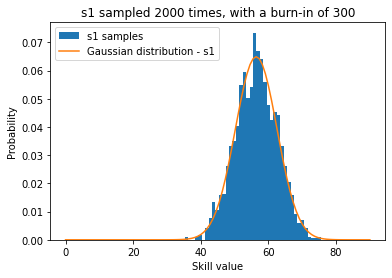

In [6]:
# Comparing histogram of the samples with the approximate Gaussian distribution, burn-in period excluded
x = np.linspace(0, 90, 100)
gauss = Gibbs2Gauss(s1_samples[burn_in:], x) # Generating a Gaussian distribution from samples

# Plots the samples together with the approximated Gaussian distribution
plt.hist(s1_samples[burn_in:], bins=40, density=True, label='s1 samples')
plt.plot(x, gauss, label= 'Gaussian distribution - s1')
plt.legend()
plt.xlabel("Skill value")
plt.ylabel("Probability")
plt.title(f"s1 sampled {num_samples} times, with a burn-in of {burn_in}")
plt.show()

#### Q5 - Assumed Density Filtering and Q6 - Using model for predictions

In [79]:
def get_posterior(initial_point, num_samples, y, beta_inv, m_s, sigma_s):
    # Calculates the posterior distribution using Gibbs sampling and uses that as prior for the next iteration 

    point = np.array(initial_point)
    samples = np.empty([num_samples+1, 2]) 
    samples[0] = point
    A = np.array([[1, -1]])
    
    # Gibbs sampling
    for i in range(num_samples):
        s1_sample, s2_sample = samples[i]
        if y == 1:
            t = stats.truncnorm.rvs(a=-(s1_sample - s2_sample) / np.sqrt(beta_inv), b=np.inf, loc=(
                s1_sample - s2_sample), scale=np.sqrt(beta_inv))  # p(t|s1, s2, y)
        elif y == -1:
            t = stats.truncnorm.rvs(a=-np.inf, b=0, loc=(s1_sample - s2_sample), scale=np.sqrt(beta_inv))
            
        S = np.linalg.inv(np.linalg.inv(sigma_s) + (beta_inv)**(-1) * (A.T @ A))
        m = S @ (np.linalg.inv(sigma_s) @ m_s + beta_inv**(-1) * A.T * t)

        point = np.random.multivariate_normal(m.ravel(), S)
        samples[i+1] = point

    return m[0][0], m[1][0], S[0,0], S[1,1], point

In [8]:
def prediction(mu_s, sigma_s, beta_inv):
    # Function predicts the outcome of the game based on the skills of the two teams
    A = np.array([[1, -1]])
    mu_t = A @ mu_s
    sigma_t = beta_inv + A @ sigma_s @ A.T
    p = stats.norm.cdf(0, loc=mu_t, scale=np.sqrt(sigma_t))
    # Returns 1 if Player 1 wins, and -1 if Player 2 wins
    return -1 if p > 0.5 else 1 

In [9]:
# Reads the data
serie_A_data = pd.read_csv('SerieA.csv', delimiter=',')
serie_A_data.head()

,yyyy-mm-dd,HH:MM,team1,team2,score1,score2
0,2018-08-18,18:00,Chievo,Juventus,2,3
1,2018-08-18,20:30,Lazio,Napoli,1,2
2,2018-08-19,18:00,Torino,Roma,0,1
3,2018-08-19,20:30,Sassuolo,Inter,1,0
4,2018-08-19,20:30,Parma,Udinese,2,2


In [10]:
# Deciding whether to shuffle the data or not
serie_A_shuffle = serie_A_data.sample(frac = 1)
serie_A_data = serie_A_data # or = serie_A_shuffle

In [11]:
# Iteration through the data set and creating a dataframe with each team and their initial skill distribution
unique_teams = pd.concat([serie_A_data['team1'], serie_A_data['team2']]).unique()
skills_df = pd.DataFrame({'team': unique_teams,
    'mu': [mu_prior] * len(unique_teams),
    'sigma': [sigma_prior] * len(unique_teams),
    's' : np.random.normal(mu_prior, np.sqrt(sigma_prior))
})
skills_history = {team: [(mu_prior, sigma_prior)] for team in list(unique_teams)}

# Storing game outcomes for prediction rate
pred_wins_team1 = []
true_wins_team1 = []

# Assumed density filtering
for _, match_instance in tqdm(serie_A_data.iterrows(), total=serie_A_data.shape[0], desc="Processing Matches", leave=True, position=0, unit='match'):
    team1, team2, score1, score2 = match_instance['team1'], match_instance['team2'], match_instance['score1'], match_instance['score2']
    
    # If draw, skip the result
    if score1 == score2:
        continue
    
    # Collect the values of parameters
    mu1 = skills_df.loc[skills_df['team'] == team1, 'mu'].values[0]
    sigma1 = skills_df.loc[skills_df['team'] == team1, 'sigma'].values[0]
    mu2 = skills_df.loc[skills_df['team'] == team2, 'mu'].values[0]
    sigma2 = skills_df.loc[skills_df['team'] == team2, 'sigma'].values[0]
    s1 = skills_df.loc[skills_df['team'] == team1, 's'].values[0]
    s2 = skills_df.loc[skills_df['team'] == team2, 's'].values[0]

    # Check the result of the game
    y = 1 if score1 > score2 else -1

    # Predicts the outcome and store the true result
    y_pred = prediction(mu_s = np.array([[mu1], [mu2]]),
                        sigma_s = np.array([[sigma1, 0], [0, sigma2]]),
                        beta_inv = beta_inv)
    
    pred_wins_team1.append(y_pred)
    true_wins_team1.append(y)

    # Gather new values from Gibbs sampling
    mu1_new, mu2_new, sigma1_new, sigma2_new, point = get_posterior(initial_point = [s1, s2],
                                                            num_samples = num_samples,
                                                            y = y,
                                                            beta_inv = beta_inv,
                                                            m_s = np.array([[mu1], [mu2]]),
                                                            sigma_s = np.array([[sigma1, 0], [0, sigma2]]))
    
    # Store the new values
    skills_history[team1].append((mu1_new, sigma1_new))
    skills_history[team2].append((mu2_new, sigma2_new))

    # Replacing the old values with the new ones
    skills_df.loc[skills_df['team'] == team1, 'mu'] = mu1_new
    skills_df.loc[skills_df['team'] == team1, 'sigma'] = sigma1_new
    skills_df.loc[skills_df['team'] == team2, 'mu'] = mu2_new
    skills_df.loc[skills_df['team'] == team2, 'sigma'] = sigma2_new
    skills_df.loc[skills_df['team'] == team1, 's'] = point[0]
    skills_df.loc[skills_df['team'] == team2, 's'] = point[1]

# Calculate the prediction rate 
r = sum(1 for pred, true in zip(pred_wins_team1, true_wins_team1) if pred == true)/len(true_wins_team1)
print(f"Prediction Rate = {round(r, 3)}")


Processing Matches:  20%|██        | 77/380 [00:10<00:43,  7.01match/s]


KeyboardInterrupt: 

In [22]:
# Prints a table of the teams sorted by the mean value of their skills
sorted_skills_df = skills_df.sort_values(by='mu', ascending=False)

for i, (index, row) in enumerate(sorted_skills_df.iterrows()):
    team = row['team']
    mu = row['mu']
    sigma = row['sigma']
    print(f"{i+1:2d} -- Team: {team:<15s} | mu: {mu:>7.2f} | sigma: {sigma:>7.2f}")

 1 -- Team: Juventus        | mu:  105.28 | sigma:    0.05
 2 -- Team: Spal            | mu:   70.43 | sigma:    0.05
 3 -- Team: Sassuolo        | mu:   67.71 | sigma:    0.07
 4 -- Team: Napoli          | mu:   66.18 | sigma:    0.05
 5 -- Team: Fiorentina      | mu:   65.38 | sigma:    0.07
 6 -- Team: Genoa           | mu:   44.68 | sigma:    0.06
 7 -- Team: Udinese         | mu:   36.39 | sigma:    0.05
 8 -- Team: Roma            | mu:   34.63 | sigma:    0.05
 9 -- Team: Atalanta        | mu:   25.22 | sigma:    0.05
10 -- Team: Empoli          | mu:   22.62 | sigma:    0.05
11 -- Team: Sampdoria       | mu:   17.50 | sigma:    0.05
12 -- Team: Inter           | mu:   15.39 | sigma:    0.05
13 -- Team: Milan           | mu:   14.30 | sigma:    0.05
14 -- Team: Torino          | mu:    5.99 | sigma:    0.06
15 -- Team: Cagliari        | mu:    3.48 | sigma:    0.05
16 -- Team: Lazio           | mu:   -0.24 | sigma:    0.05
17 -- Team: Parma           | mu:  -10.98 | sigma:    0.

#### Q8 - Message-passing Algorithm

In [16]:

def multiplyGauss(m1, s1, m2, s2):
    s = 1 / (1 / s1 + 1 / s2)
    m = (m1 / s1 + m2 / s2) * s
    return m, s


def divideGauss(m1, s1, m2, s2):
    m, s = multiplyGauss(m1, s1, m2, -s2)
    return m, s


def truncGaussMM(a, b, m0, s0):
    a_scaled, b_scaled = (a - m0) / np.sqrt(s0), (b - m0) / np.sqrt(s0)
    m = stats.truncnorm.mean(a_scaled, b_scaled, loc=m0, scale=np.sqrt(s0))
    s = stats.truncnorm.var(a_scaled, b_scaled, loc=m0, scale=np.sqrt(s0))
    return m, s

150 300
150.0 300.0


/var/folders/ys/b3y605yj63v2_9hpsb79b4kc0000gn/T/ipykernel_21140/3018777626.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  s = 1 / (1 / s1 + 1 / s2)
/var/folders/ys/b3y605yj63v2_9hpsb79b4kc0000gn/T/ipykernel_21140/3018777626.py:3: RuntimeWarning: invalid value encountered in double_scalars
  m = (m1 / s1 + m2 / s2) * s


ValueError: autodetected range of [nan, nan] is not finite

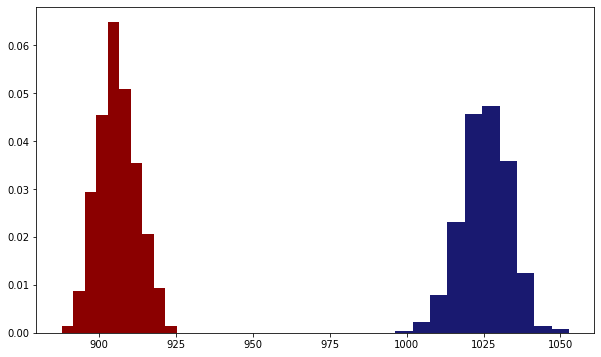

In [81]:
num_samples = 10000   # Nr of Gibbs samples

# Prior parameters
mu1 = 1050
sigma1 = 200

mu2 = 900
sigma2 = 50

beta_inv = 50
y = 1    # If y = 1, player 1 wins. y = -1, player 2 wins

# Initial samples for Gibbs
s1 = np.random.normal(mu1, np.sqrt(sigma1))
s2 = np.random.normal(mu2, np.sqrt(sigma2))

mu1_gibbs, mu2_gibbs, sigma1_gibbs, sigma2_gibbs, _ = get_posterior(initial_point=[s1, s2],
                                                                    num_samples=num_samples,
                                                                    y=y,
                                                                    beta_inv=beta_inv,
                                                                    m_s=np.array(
                                                                        [[mu1], [mu2]]),
                                                                    sigma_s=np.array([[sigma1, 0], [0, sigma2]]))

mt, st = truncGaussMM(0, np.inf, mu1 - mu2, beta_inv + sigma1 +
                      sigma2) if y == 1 else truncGaussMM(-np.inf, 0, mu1 - mu2, beta_inv + sigma1 + sigma2)
print(mu1 - mu2, beta_inv + sigma1 + sigma2)
print(mt, st)

m6, s6 = divideGauss(mt, st, mu1 - mu2, beta_inv + sigma1 + sigma2)

m71, m72 = m6 + mu2, -m6 + mu1
s71, s72 = beta_inv + sigma2 + s6, beta_inv + sigma1 + s6

mu1_MP, sigma1_MP = multiplyGauss(mu1, sigma1, m71, s71)
mu2_MP, sigma2_MP = multiplyGauss(mu2, sigma2, m72, s72)

num_samples_hist = 400
S1_gibbs_samples = np.random.normal(
    mu1_gibbs, np.sqrt(sigma1_gibbs), num_samples_hist)
S2_gibbs_samples = np.random.normal(
    mu2_gibbs, np.sqrt(sigma2_gibbs), num_samples_hist)

S1_MP_samples = np.random.normal(mu1_MP, np.sqrt(sigma1_MP), num_samples_hist)
S2_MP_samples = np.random.normal(mu2_MP, np.sqrt(sigma2_MP), num_samples_hist)


plt.figure(figsize=(10, 6))
plt.hist(S1_gibbs_samples, density=True,
         label='S1 (Gibbs)', color='midnightblue')
plt.hist(S2_gibbs_samples, density=True, label='S2 (Gibbs)', color='darkred')
plt.hist(S1_MP_samples, density=True, label='S1 (MP)', color='blue')
plt.hist(S2_MP_samples, density=True, label='S2 (MP)', color='red')


plt.xlabel('Skill')
plt.ylabel('Frequency')
plt.title(f'Histogram')
plt.legend()
plt.show()


#### Q9 - Own data

In [23]:
def id2name(team_id, team_df):
    # Function takes in a team ID and returns the team name
    name = team_df.loc[team_df['TEAM_ID']==team_id, 'NICKNAME'].values[0]
    return name

In [24]:
# Load the NBA game data
NBA_games = pd.read_csv('games.csv', delimiter=',')
NBA_games = NBA_games[NBA_games['SEASON'] == 2022]
NBA_games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


In [26]:
# Load team names
teams = pd.read_csv('teams.csv', delimiter=',')
teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


In [27]:
# Merging the two data sets 
merged_df = NBA_games.merge(teams, left_on='HOME_TEAM_ID', right_on='TEAM_ID', how='left')\
    .merge(teams, left_on='VISITOR_TEAM_ID', right_on='TEAM_ID', how='left')
merged_df['HOME_TEAM'] = merged_df['CITY_x'] + ' ' + merged_df['NICKNAME_x']
merged_df['VISITOR_TEAM'] = merged_df['CITY_y'] + ' ' + merged_df['NICKNAME_y']

NBA_games = merged_df[['GAME_DATE_EST', 'HOME_TEAM', 'VISITOR_TEAM', 'PTS_home', 'PTS_away', 'HOME_TEAM_WINS']]\
    .rename(columns={'HOME_TEAM_WINS': 'Home_Team_Win_boo'})
NBA_games.head()

,GAME_DATE_EST,HOME_TEAM,VISITOR_TEAM,PTS_home,PTS_away,Home_Team_Win_boo
0,2022-12-22,New Orleans Pelicans,San Antonio Spurs,126.0,117.0,1
1,2022-12-22,Utah Jazz,Washington Wizards,120.0,112.0,1
2,2022-12-21,Cleveland Cavaliers,Milwaukee Bucks,114.0,106.0,1
3,2022-12-21,Philadelphia 76ers,Detroit Pistons,113.0,93.0,1
4,2022-12-21,Atlanta Hawks,Chicago Bulls,108.0,110.0,0


In [28]:
# Set hyperparameters for Q9
beta_inv = 1/30
num_samples = 400
mu_0 = 100
sigma_0 = 50

# Storing game outcomes for prediction rate
pred_wins_team1 = []
true_wins_team1 = []

# Iterate through the data set to find all different teams and their skills
unique_teams = pd.concat([NBA_games['HOME_TEAM'], NBA_games['VISITOR_TEAM']]).unique()
skills_df = pd.DataFrame({'team': unique_teams,
    'mu': [mu_0] * len(unique_teams),
    'sigma': [sigma_0] * len(unique_teams),
    's' : np.random.normal(mu_0, np.sqrt(sigma_0))
})
skills_history = {team: [(mu_0, sigma_0)] for team in list(unique_teams)}

for _, match_instance in tqdm(NBA_games.iterrows(), total=NBA_games.shape[0], desc="Processing Matches", leave=True, position=0, unit='match'):
    team1, team2, home_team_wins = match_instance['HOME_TEAM'], match_instance['VISITOR_TEAM'], match_instance['Home_Team_Win_boo']
    
    # Collect match information
    mu1 = skills_df.loc[skills_df['team'] == team1, 'mu'].values[0]
    sigma1 = skills_df.loc[skills_df['team'] == team1, 'sigma'].values[0]
    mu2 = skills_df.loc[skills_df['team'] == team2, 'mu'].values[0]
    sigma2 = skills_df.loc[skills_df['team'] == team2, 'sigma'].values[0]
    s1 = skills_df.loc[skills_df['team'] == team1, 's'].values[0]
    s2 = skills_df.loc[skills_df['team'] == team2, 's'].values[0]

    # Check the result of the game
    y = 1 if home_team_wins else -1

    # Predicts the outcome and store the true result
    y_pred = prediction(mu_s = np.array([[mu1], [mu2]]),
                        sigma_s = np.array([[sigma1, 0], [0, sigma2]]),
                        beta_inv = beta_inv)
    
    pred_wins_team1.append(y_pred)
    true_wins_team1.append(y)

    mu1_new, mu2_new, sigma1_new, sigma2_new, point = get_posterior(initial_point = [s1, s2],
                                                            num_samples = num_samples,
                                                            y = y,
                                                            beta_inv = beta_inv,
                                                            m_s = np.array([[mu1], [mu2]]),
                                                            sigma_s = np.array([[sigma1, 0], [0, sigma2]]))
    
    # Store the new values
    skills_history[team1].append((mu1_new, sigma1_new))
    skills_history[team2].append((mu2_new, sigma2_new))

    # Replace old values with the new ones
    skills_df.loc[skills_df['team'] == team1, 'mu'] = mu1_new
    skills_df.loc[skills_df['team'] == team1, 'sigma'] = sigma1_new
    skills_df.loc[skills_df['team'] == team2, 'mu'] = mu2_new
    skills_df.loc[skills_df['team'] == team2, 'sigma'] = sigma2_new
    skills_df.loc[skills_df['team'] == team1, 's'] = point[0]
    skills_df.loc[skills_df['team'] == team2, 's'] = point[1]

# Calculate the prediction rate 
r = sum(1 for pred, true in zip(pred_wins_team1, true_wins_team1) if pred == true)/len(true_wins_team1)
print(f"Prediction Rate = {round(r, 3)}")

Processing Matches: 100%|██████████| 542/542 [01:13<00:00,  7.35match/s]

Prediction Rate = 0.557


In [ ]:
# Figure showing the evolution of skills for all the teams
plt.figure(figsize=(12, 6))
ax = plt.gca()

sns.set_style("whitegrid")

for team, mu_sigma_values in skills_history.items():
    mu_values = [mu for mu, sigma in mu_sigma_values]
    x_values = range(len(mu_values))
    sns.lineplot(x=x_values, y=mu_values, ax=ax, label=team)

plt.title("Evolution of NBA Team Skills")
plt.xlabel('Match Number')
plt.ylabel('Mu')
plt.legend(title='Team', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.savefig('NBA_team_skills.png', bbox_inches='tight')
plt.show()


In [ ]:
# Prints a table of all team's 
sorted_skills_df = skills_df.sort_values(by='mu', ascending=False)

for i, (index, row) in enumerate(sorted_skills_df.iterrows()):
    team = row['team']
    mu = row['mu']
    sigma = row['sigma']
    print(f"{i+1:2d} -- Team: {team:<15s} | mean: {mu:>7.2f} | variance: {sigma:>7.4f}")

#### Q10 - Extended data set

In [6]:
# Reads the new data set for season 2017-2018
serie_A_data_2 = pd.read_csv('season-1718.csv', delimiter=',')
serie_A_data_2 = serie_A_data_2[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
serie_A_data_2.head()

,HomeTeam,AwayTeam,FTHG,FTAG
0,Juventus,Cagliari,3,0
1,Verona,Napoli,1,3
2,Atalanta,Roma,0,1
3,Bologna,Torino,1,1
4,Crotone,Milan,0,3


In [7]:
# Appending the new data set to the other data frame
data = serie_A_data_2.rename(columns={"HomeTeam":"team1", "AwayTeam": "team2", "FTHG":"score1", "FTAG":"score2"}, errors="raise" )
new_data = serie_A_data.append(data)
new_data.tail()

/var/folders/ys/b3y605yj63v2_9hpsb79b4kc0000gn/T/ipykernel_20092/2004657451.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = serie_A_data.append(data)


,yyyy-mm-dd,HH:MM,team1,team2,score1,score2
375,NaN,NaN,Milan,Fiorentina,5,1
376,NaN,NaN,Napoli,Crotone,2,1
377,NaN,NaN,Sassuolo,Roma,0,1
378,NaN,NaN,Spal,Sampdoria,3,1
379,NaN,NaN,Udinese,Bologna,1,0


In [8]:
# Set hyperparameters for Q10
beta_inv = 1
num_samples = 2000
mu_0 = 25
sigma_0 = 40


In [10]:
pred_wins_team1 = []
true_wins_team1 = []

unique_teams = pd.concat([new_data['team1'], new_data['team2']]).unique()
skills_df = pd.DataFrame({'team': unique_teams,
    'mu': [mu_0] * len(unique_teams),
    'sigma': [sigma_0] * len(unique_teams),
    's' : np.random.normal(mu_0, np.sqrt(sigma_0))
})
skills_history = {team: [(mu_0, sigma_0)] for team in list(unique_teams)}

for _, match_instance in tqdm(new_data.iterrows(), total=new_data.shape[0], desc="Processing Matches", leave=True, position=0, unit='match'):
    team1, team2, score1, score2 = match_instance['team1'], match_instance['team2'], match_instance['score1'], match_instance['score2']
    
    # If draw, skip the result
    if score1 == score2:
        continue

    # Collect match information
    mu1 = skills_df.loc[skills_df['team'] == team1, 'mu'].values[0]
    sigma1 = skills_df.loc[skills_df['team'] == team1, 'sigma'].values[0]
    mu2 = skills_df.loc[skills_df['team'] == team2, 'mu'].values[0]
    sigma2 = skills_df.loc[skills_df['team'] == team2, 'sigma'].values[0]
    s1 = skills_df.loc[skills_df['team'] == team1, 's'].values[0]
    s2 = skills_df.loc[skills_df['team'] == team2, 's'].values[0]
    
    # Check the result of the game
    y = 1 if score1 > score2 else -1
    
    # Predicts the outcome and store the true result
    y_pred = prediction(mu_s = np.array([[mu1], [mu2]]),
                        sigma_s = np.array([[sigma1, 0], [0, sigma2]]),
                        beta_inv = beta_inv)
    
    pred_wins_team1.append(y_pred)
    true_wins_team1.append(y)

    mu1_new, mu2_new, sigma1_new, sigma2_new, point = get_posterior(initial_point = [s1, s2],
                                                            num_samples = num_samples,
                                                            y = y,
                                                            beta_inv = beta_inv,
                                                            m_s = np.array([[mu1], [mu2]]),
                                                            sigma_s = np.array([[sigma1, 0], [0, sigma2]]))
    
    # Store the new values
    skills_history[team1].append((mu1_new, sigma1_new))
    skills_history[team2].append((mu2_new, sigma2_new))

    # Replace old values with the new ones
    skills_df.loc[skills_df['team'] == team1, 'mu'] = mu1_new
    skills_df.loc[skills_df['team'] == team1, 'sigma'] = sigma1_new
    skills_df.loc[skills_df['team'] == team2, 'mu'] = mu2_new
    skills_df.loc[skills_df['team'] == team2, 'sigma'] = sigma2_new
    skills_df.loc[skills_df['team'] == team1, 's'] = point[0]
    skills_df.loc[skills_df['team'] == team2, 's'] = point[1]
    
# Calculate the prediction rate 
r = sum(1 for pred, true in zip(pred_wins_team1, true_wins_team1) if pred == true)/len(true_wins_team1)
print(f"Prediction Rate = {round(r, 3)}")


Processing Matches: 100%|██████████| 760/760 [01:41<00:00,  7.46match/s]

Prediction Rate = 0.624
